In [1]:
import pymc
import numpy as np
import sklearn.datasets
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Data

### 1.1 Boston Housing Prices

In [2]:
boston_prices = sklearn.datasets.load_boston()

In [35]:
X = boston_prices['data']
features = boston_prices['feature_names']
y_price = boston_prices['target']

In [4]:
boston_prices.viewkeys()

dict_keys(['data', 'feature_names', 'DESCR', 'target'])

In [5]:
print X.shape
print y.shape

(506, 13)
(506,)


In [6]:
boston_prices['DESCR']

"Boston House Prices dataset\n\nNotes\n------\nData Set Characteristics:  \n\n    :Number of Instances: 506 \n\n    :Number of Attributes: 13 numeric/categorical predictive\n    \n    :Median Value (attribute 14) is usually the target\n\n    :Attribute Information (in order):\n        - CRIM     per capita crime rate by town\n        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.\n        - INDUS    proportion of non-retail business acres per town\n        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)\n        - NOX      nitric oxides concentration (parts per 10 million)\n        - RM       average number of rooms per dwelling\n        - AGE      proportion of owner-occupied units built prior to 1940\n        - DIS      weighted distances to five Boston employment centres\n        - RAD      index of accessibility to radial highways\n        - TAX      full-value property-tax rate per $10,000\n        - PTRATIO  pupil-teac

In [7]:
# NOX      nitric oxides concentration (parts per 10 million)

X_nox = X[:, 4] 

### 1.2 Automobile

In [4]:
automobile = pd.read_csv('imports-85.data', header=None)

In [5]:
automobile.head()

# Description: http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.names

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [18]:
price = automobile.ix[:, 25]

not_null = price != '?'

price = price[not_null]

engine_size = automobile.ix[:, 16]
engine_size = engine_size[not_null]

X_engine_size = np.array([float(a) for a in engine_size])
y_car_price = np.array([float(a) for a in price])

In [20]:
print (X_engine_size.shape, y_car_price.shape)

((201,), (201,))


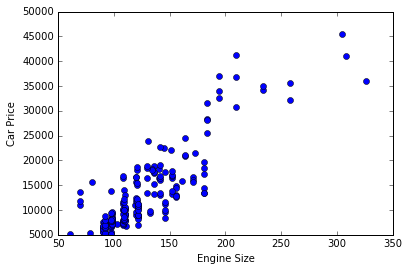

In [22]:
plt.plot(X_engine_size, y_car_price, 'o')
plt.xlabel('Engine Size')
plt.ylabel('Car Price')

### 1.3 Sigmoid

In [2]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))

X_all_sig = np.arange(-10, 10, 0.05)
print X_all_sig.shape

(400,)


In [31]:
X_sig = np.random.choice(X_all_sig, 50)
y_sig = sigmoid(X_sig)

In [32]:
X_sig.shape

(50,)

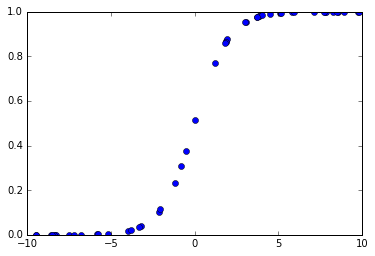

In [33]:
plt.plot(X_sig, y_sig, 'o')

## 2. Model Setup: y = a0 + a1 * x

In [34]:
# Stochastic

a0 = pymc.Normal('a0', 0, 0.001)
a1 = pymc.Normal('a1', 0, 0.001)

In [35]:
# Deterministic

X = pymc.Normal('sig', 0, 1, value = X_sig, observed = True)

In [36]:
@pymc.deterministic
def linear_model(a0 = a0, a1 = a1, x = X_sig):
    return a0 + a1 * x

# pymc.deterministic - This tells pymc that model is a function that depends on stochastic objects, 
# but is itself a deterministic function of them (it's a function of random variables, 
# not a random variable itself).

In [37]:
y = pymc.Normal('price', linear_model, 1, value = y_sig, observed = True)

In [38]:
model = pymc.Model([linear_model, a0, a1, y_sig, X_sig])

## 3. Learning: MCMC

In [39]:
mcmc = pymc.MCMC(model)

In [40]:
mcmc.sample(10000, 2000)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.2 sec

(array([    4.,     0.,     6.,    39.,     3.,    72.,    72.,   141.,
          321.,   411.,   330.,   667.,   608.,  1049.,   689.,   574.,
          596.,   542.,   547.,   595.,   210.,   258.,   153.,    42.,
           38.,    20.,     2.,     8.,     0.,     3.]),
 array([-0.01907783, -0.01298329, -0.00688875, -0.00079421,  0.00530032,
         0.01139486,  0.0174894 ,  0.02358394,  0.02967848,  0.03577302,
         0.04186756,  0.0479621 ,  0.05405664,  0.06015118,  0.06624572,
         0.07234026,  0.0784348 ,  0.08452934,  0.09062387,  0.09671841,
         0.10281295,  0.10890749,  0.11500203,  0.12109657,  0.12719111,
         0.13328565,  0.13938019,  0.14547473,  0.15156927,  0.15766381,
         0.16375835]),
 <a list of 30 Patch objects>)

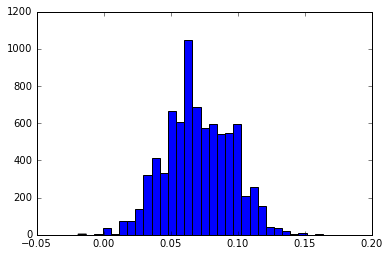

In [41]:
# Posterior of 'a1'

plt.hist(mcmc.trace('a1')[:], bins=30)

(array([  1.00000000e+00,   1.80000000e+01,   2.80000000e+01,
          6.90000000e+01,   7.10000000e+01,   1.48000000e+02,
          1.17000000e+02,   1.96000000e+02,   1.43000000e+02,
          4.01000000e+02,   2.63000000e+02,   4.26000000e+02,
          6.85000000e+02,   3.82000000e+02,   3.63000000e+02,
          6.45000000e+02,   1.18100000e+03,   3.71000000e+02,
          4.68000000e+02,   5.29000000e+02,   3.49000000e+02,
          3.16000000e+02,   3.30000000e+02,   2.18000000e+02,
          1.12000000e+02,   9.20000000e+01,   6.00000000e+01,
          9.00000000e+00,   8.00000000e+00,   1.00000000e+00]),
 array([ 0.06072538,  0.09077363,  0.12082187,  0.15087011,  0.18091836,
         0.2109666 ,  0.24101485,  0.27106309,  0.30111134,  0.33115958,
         0.36120783,  0.39125607,  0.42130432,  0.45135256,  0.48140081,
         0.51144905,  0.5414973 ,  0.57154554,  0.60159379,  0.63164203,
         0.66169028,  0.69173852,  0.72178676,  0.75183501,  0.78188325,
         0.81

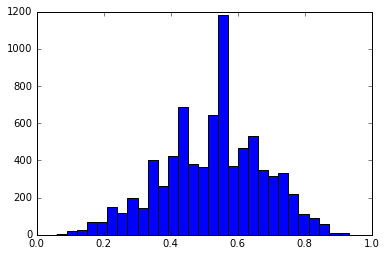

In [42]:
# Posterior of 'a0'

plt.hist(mcmc.trace('a0')[:], bins=30)

In [43]:
mean_a0 = np.mean(mcmc.trace('a0')[:])
mean_a1 = np.mean(mcmc.trace('a1')[:])

print ('Mean a0: ', mean_a0)
print ('Std. Dev. a0: ', np.var(mcmc.trace('a0')[:])**0.5)

print '\n'
print ('Mean a1: ', mean_a1)
print ('Std. Dev. a1: ', np.var(mcmc.trace('a1')[:])**0.5)

sd_a0 = np.var(mcmc.trace('a1')[:])**0.5
sd_a1 = np.var(mcmc.trace('a1')[:])**0.5

a0_samples = [round(s, 2) for s in mcmc.trace('a0')[:]]
a1_samples = [round(s, 2) for s in mcmc.trace('a1')[:]]

from scipy import stats
mode_a0 = stats.mode(a0_samples)[0][0]
mode_a1 = stats.mode(a1_samples)[0][0]

print ('Mode a0: ', mode_a0)
print ('Mode a1: ', mode_a1)

('Mean a0: ', 0.52602546848681664)
('Std. Dev. a0: ', 0.15090263420801589)


('Mean a1: ', 0.070511055846759346)
('Std. Dev. a1: ', 0.024923011389564535)
('Mode a0: ', 0.56999999999999995)
('Mode a1: ', 0.059999999999999998)


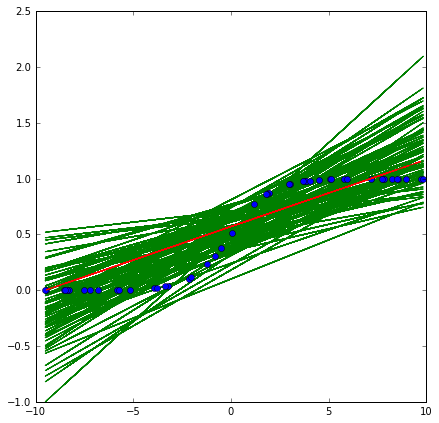

In [44]:
sample_ixs = np.random.choice(np.arange(len(a0_samples)), size=100)
all_samples = zip(a0_samples, a1_samples)

sample_lines = [all_samples[i] for i in sample_ixs]

plt.figure(figsize= (7, 7))

for line in sample_lines:
    plt.plot(X_sig, line[0] + line[1] * X_sig, 'g')
    
plt.plot(X_sig, y_sig, 'o', X_sig, mode_a0 + X_sig * mode_a1, 'r--')